In [1]:
import torch
import wandb
from tqdm.auto import tqdm
from torchmetrics import AUROC, ROC, Accuracy
from models import DGCNN, SimpleGAT
from dataset import PointCloudFromParquetDataset
import torch_geometric
import copy
import matplotlib.pyplot as plt

/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

import random
random.seed(42)

import numpy as np
np.random.seed(42)

In [3]:
DEVICE = "cuda"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
TEST_SIZE = 0.2
VAL_SIZE = 0.15
NUM_EPOCHS = 5

In [4]:
run_0_path = "/scratch/gsoc/parquet_ds/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet"
run_1_path = "/scratch/gsoc/parquet_ds/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet"
run_2_path = "/scratch/gsoc/parquet_ds/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet"


run_0_ds = PointCloudFromParquetDataset(run_0_path,)
run_1_ds = PointCloudFromParquetDataset(run_1_path,)
run_2_ds = PointCloudFromParquetDataset(run_2_path,)

combined_dset = torch.utils.data.ConcatDataset([run_0_ds, run_1_ds, run_2_ds])

In [5]:
test_size = int(len(combined_dset) * TEST_SIZE)
val_size = int(len(combined_dset) * VAL_SIZE)
train_size = len(combined_dset) - val_size - test_size

train_dset, val_dset, test_dset = torch.utils.data.random_split(
    combined_dset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42),
)


train_loader = torch_geometric.data.DataLoader(train_dset, shuffle=True, batch_size=TRAIN_BATCH_SIZE, pin_memory=True, num_workers=16)
val_loader = torch_geometric.data.DataLoader(val_dset, shuffle=False, batch_size=VAL_BATCH_SIZE, pin_memory=True, num_workers=16)
test_loader = torch_geometric.data.DataLoader(test_dset, shuffle=False, batch_size=TEST_BATCH_SIZE, num_workers=16)

/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


The approach only uses data from the energy deposits, as it was not clear whether $p_T$ and $m_0$ was allowed to be used for classification

In [6]:
def train(num_epochs, model, criterion, optimizer, train_loader, val_loader, device):
    best_model = copy.deepcopy(model).to('cpu', non_blocking=True)
    best_val_auroc = 0
    train_auroc = AUROC(num_classes=None).to(device, non_blocking=True)
    val_auroc = AUROC(num_classes=None).to(device, non_blocking=True)
    acc = Accuracy().to(device, non_blocking=True)
    
    for epoch in range(num_epochs):
        model.train()
        tqdm_iter = tqdm(train_loader, total=len(train_loader))
        tqdm_iter.set_description(f"Epoch {epoch}")

        for it, data in enumerate(tqdm_iter):
            optimizer.zero_grad()

            data = data.to(device, non_blocking=True)
            y = data.y

            out = model(data)

            loss = criterion(out, y.unsqueeze(-1))

            pred = torch.sigmoid(out.detach()).squeeze()
            acc.update(pred, y.detach().long())
            train_auroc.update(pred, y.detach().long())

            tqdm_iter.set_postfix(loss=loss.item(), acc=acc.compute().item())
            wandb.log({
                "train_loss": loss.item(),
                "train_acc": acc.compute().item(),
                "train_step": (it * TRAIN_BATCH_SIZE) + epoch * train_size
            })

            loss.backward()
            optimizer.step()

        wandb.log({
            "train_auroc": train_auroc.compute(),
            "train_epoch": epoch
        })
        train_auroc.reset()
        acc.reset()

        model.eval()
        val_tqdm_iter = tqdm(val_loader, total=len(val_loader))
        val_tqdm_iter.set_description(f"Validation Epoch {epoch}")

        for it, data in enumerate(val_tqdm_iter):
            with torch.no_grad():
                data = data.to(device, non_blocking=True)
                y = data.y

                out = model(data)

                loss = criterion(out, y.unsqueeze(-1))

                pred = torch.sigmoid(out.detach()).squeeze()
                acc.update(pred, y.detach().to(torch.long, non_blocking=True))
                val_auroc.update(pred, y.to(torch.long, non_blocking=True))

                val_tqdm_iter.set_postfix(loss=loss.item(), acc=acc.compute().item())
                wandb.log({
                    "val_loss": loss.item(),
                    "val_acc": acc.compute().item(),
                    "val_step": (it * VAL_BATCH_SIZE) + epoch * val_size
                })

        val_auroc_val = val_auroc.compute()
        wandb.log({
            "val_auroc": val_auroc_val,
            "val_epoch": epoch
        })
        
        if val_auroc_val > best_val_auroc:
            best_model = copy.deepcopy(model).to('cpu', non_blocking=True)
            best_val_auroc = val_auroc_val
        
        val_auroc.reset()
        acc.reset()
        
    del model

    return best_model.to(device, non_blocking=True)

In [7]:
def test(model, test_loader, device):
    model.eval()
    test_auroc = AUROC(num_classes=None).to(device, non_blocking=True)
    test_acc = Accuracy().to(device, non_blocking=True)
    test_roc_non_wandb = ROC(num_classes=None).to(device, non_blocking=True)
    tqdm_iter = tqdm(test_loader, total=len(test_loader))
    
    pred_list = []
    ground_truth_list = []
    
    
    for it, data in enumerate(tqdm_iter):
        with torch.no_grad():
            data = data.to(device, non_blocking=True)
            y = data.y
            
            out = model(data)
            pred = torch.sigmoid(out).squeeze()
            test_acc.update(pred, y.long())
            test_auroc.update(pred, y.long())
            test_roc_non_wandb.update(pred, y.long())
            
            pred_list.append(
                pred.cpu()
            )
            ground_truth_list.append(
                y.cpu().long()
            )
            
            tqdm_iter.set_postfix(acc=test_acc.compute().item())
            
    pred_list = torch.cat(pred_list)
    output = torch.cat([1 - pred_list.unsqueeze(-1), pred_list.unsqueeze(-1)], dim=1)
    ground_truth_list = torch.cat(ground_truth_list)
    
    wandb.log({"test_pr_curve": wandb.plot.pr_curve(ground_truth_list, output), 
               "test_roc_curve": wandb.plot.roc_curve(ground_truth_list, output)})
            
    return test_acc.compute().item(), test_auroc.compute().item(), test_roc_non_wandb.cpu().compute()

In [8]:
def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
def main(run_name, model_type='dgcnn'):
    wandb.init(name=run_name, project='gsoc-submission')
    
    if model_type == 'dgcnn':
        model = DGCNN(k=20)
    elif model_type == 'gat':
        model = SimpleGAT(k=20)
    else:
        raise ValueError(f"Invalid type MODEL: {model_type}")
        
    model = model.to(DEVICE)
        
    opt = get_optimizer(model, lr=1e-3)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    model = train(NUM_EPOCHS, model, criterion, opt, train_loader, val_loader, DEVICE)
    test_acc, test_auroc, test_roc = test(model, test_loader, DEVICE)
    print(f"Model on Test dataset: Accuracy: {test_acc} \t AUROC: {test_auroc}")
    
    fpr, tpr, threshold = test_roc
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()
    
    print(f"Thresholds: {threshold.numpy()}")
    
    wandb.finish()
    
    return model

**Running the ParticleNet based DGCNN Model**

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jai-bardhan (use `wandb login --relogin` to force relogin)


/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Validation Epoch 4: 100%|██████████| 327/327 [00:58<00:00,  5.56it/s, acc=0.726, loss=0.637]
/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 436/436 [01:18<00:00,  5.59it/s, acc=0.727]
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


Model on Test dataset: Accuracy: 0.7272172570228577 	 AUROC: 0.7936313152313232


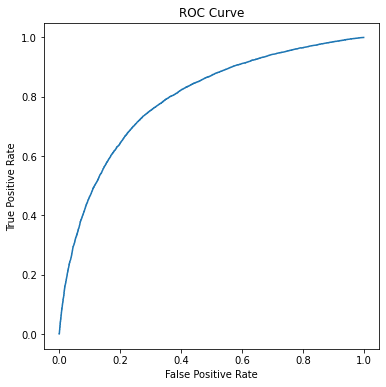

Thresholds: [2.         1.         0.9995807  ... 0.03252365 0.03249175 0.03118908]



train_acc,▁▃▄▄▅▅▅▅▆▇▇▇▇▇▇▇▅▆▆▇▇▇▇▇█▇▇█▇█▇▇█▇██████
train_auroc,▁▅▇▇█
train_epoch,▁▃▅▆█
train_loss,▅▅▅▅▃▅▄▄▆▁▃█▄▆▃▄▆▄▄▃█▅▃▁▅▇▄▂▃▄▆▅▂▄▃▂▁▄▄▃
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▇███████▇███████▂▁▁▁▁▁▁▁████████████████
val_auroc,▅▆▁██
val_epoch,▁▃▅▆█
val_loss,▂▄▆▅▄▆▁▅▅▂▅▄▆▅▅▅▅▇▆▆▃▆█▇▄▁▁▂▂▅▃▆▁▃▅▄▃▄▃▃
val_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,0.72254


In [10]:
dgcnn_model = main('task_3_dgcnn').to('cpu', non_blocking=True)

In [11]:
wandb.finish()

In [12]:
torch.save(dgcnn_model.state_dict(), "dgcnn_model.pt")

**Running the GAT Model**

/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Validation Epoch 4: 100%|██████████| 327/327 [00:56<00:00,  5.77it/s, acc=0.707, loss=0.637]
/home/jai.bardhan/anaconda3/envs/ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 436/436 [01:15<00:00,  5.77it/s, acc=0.71] 
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


Model on Test dataset: Accuracy: 0.7098453044891357 	 AUROC: 0.7712491750717163


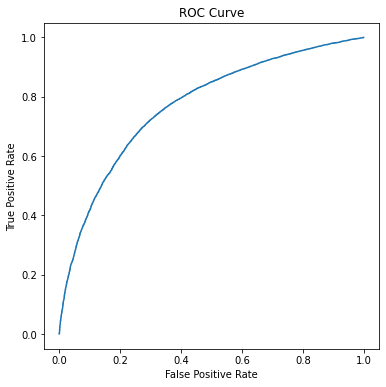

Thresholds: [2.         1.         0.9999995  ... 0.02976456 0.02935774 0.02333412]



train_acc,▁▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇██▇▇▇▇▇▇████████▇███████
train_auroc,▁▄▇▇█
train_epoch,▁▃▅▆█
train_loss,▇▆▅▄▃▅▄▄▄▆▇▅▃▃▆▅▃▅▄▅▁▆▅▆▅▁▅▂▅▆▂▇▄▃█▄▁▅▃▅
train_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_acc,▆▃▅▅▄▄▄▄▁▄▆▆▅▆▆▅▆▇█████▇▇██▇▆▆▆▆▇█████▇█
val_auroc,▁▄▇▆█
val_epoch,▁▃▅▆█
val_loss,▃▇██▅▆▂█▇▆▇▄▇▇▇▄▆▅▆▅▃▇▇▆▄▂▁▅▂▅▆█▂▄▆▄▄▆▇▂
val_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_acc,0.70419


In [13]:
gat_model = main('task_3_gat', model_type='gat').to('cpu', non_blocking=True)

In [14]:
torch.save(gat_model.state_dict(), "gat_model.pt")